In [4]:
import warnings
import pandas as pd
import re
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from gensim.models import KeyedVectors


import gensim
import matplotlib.pyplot as plt
import pandas as pd
import spacy
import string



warnings.filterwarnings("ignore")   

In [5]:
import spacy


nlp_small = spacy.load("en_core_web_sm") 
#nlp_large = spacy.load("en_core_web_lg") # large file 

stop_words_small = nlp_small.Defaults.stop_words
#stop_words_large = nlp_large.Defaults.stop_words



In [6]:
model = KeyedVectors.load(r"C:\Users\lenovo\Desktop\text_classification\word2vec\word2vec-google-news-50-pca-fp16.model")

In [7]:
def small_tokenizer(sentence):
    punctuations = string.punctuation
                   
    doc = nlp_small(sentence)  # -> tokenization

    mytokens = []
    for word in doc:
        lemma = word.lemma_.lower().strip() # removing the whitespace & lemmatization and lowercuase
        mytokens.append(lemma)

    filtered_tokens = []
    for word in mytokens:
        if word not in stop_words_small and word not in punctuations:
            filtered_tokens.append(word)

    return filtered_tokens

def large_tokenizer(sentence):
    punctuations = string.punctuation
                   
    doc = nlp_large(sentence)  # -> tokenization

    mytokens = []
    for word in doc:
        lemma = word.lemma_.lower().strip() # removing the whitespace & lemmatization and lowercuase
        mytokens.append(lemma)

    filtered_tokens = []
    for word in mytokens:
        if word not in stop_words_large and word not in punctuations:
            filtered_tokens.append(word)

    return filtered_tokens


In [8]:
data = pd.read_csv("mix_data.csv")


In [9]:
small_data = data.copy()

In [10]:
import numpy as np
def avg_vector(sent):
    vector_size = model.vectors.shape[1]
    average_vector = np.zeros(vector_size)
    valid_word_count = 0

    for word in sent:
        if word in model:
            average_vector += model[word]
            valid_word_count += 1

    if valid_word_count > 0:
        average_vector /= valid_word_count
    return average_vector

In [11]:
phrase = data["email_body"][0]
 

In [12]:
tokens = small_tokenizer(phrase)
vector = avg_vector(tokens) 

In [13]:
small_data["tokens"] = small_data["email_body"].apply(small_tokenizer)


In [ ]:
small_data.to_pickle("tokens.pkl")

In [14]:
small_data["average_vector"] = small_data["tokens"].apply(avg_vector)

In [32]:
large_data["tokens"] = large_data["email_body"].apply(large_tokenizer)


In [33]:
large_data["average_vector"] = large_data["tokens"].apply(avg_vector)

In [15]:
small_data.to_pickle("small_data.pkl")

In [78]:
large_data.to_pickle("large_data.pkl")

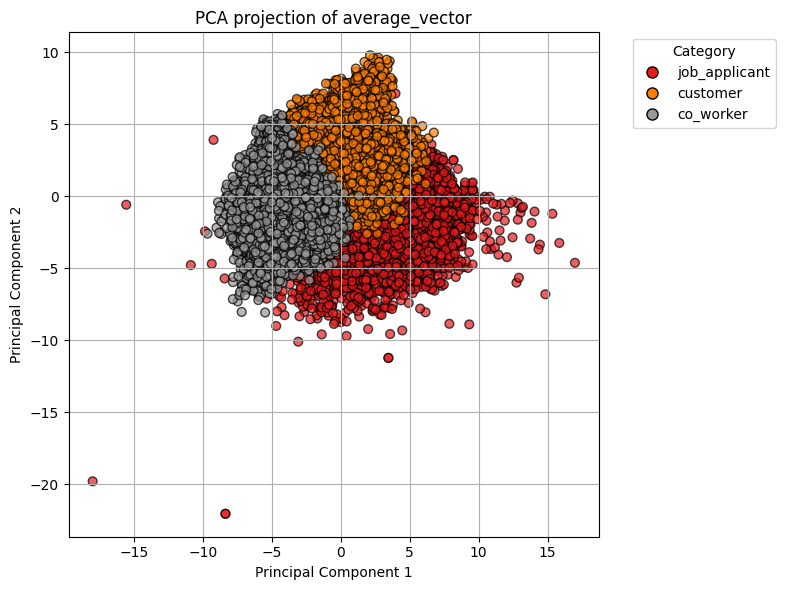

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

def plot_pca_projection(data, vector_col='average_vector', label_col='label', n_components=3, figsize=(8, 6)):
    """
    Plots the PCA projection of vectors in a dataframe.
    
    Parameters:
    - data: pandas DataFrame, must contain columns for vectors and labels
    - vector_col: str, column with vectors (as lists or numpy arrays)
    - label_col: str, column with categorical labels
    - n_components: int, number of PCA components (default 3)
    - figsize: tuple, matplotlib figure size
    
    Displays the scatter plot.
    """
    # 1. Copy & stack your vectors into a (n_samples, n_features) array
    X = data[vector_col].copy()
    X_matrix = np.vstack(X.to_numpy())

    # 2. Standardize features for PCA
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_matrix)

    # 3. Run PCA
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X_scaled)

    # 4. Encode string labels into integers
    y = data[label_col].copy()
    y_codes, y_labels = pd.factorize(y)

    # 5. Plot
    plt.figure(figsize=figsize)
    scatter = plt.scatter(
        X_pca[:, 0], X_pca[:, 1],
        c=y_codes,
        cmap="Set1",
        alpha=0.7,
        edgecolor="k",
        s=40
    )

    # 6. Legend
    handles = [
        plt.Line2D(
            [], [], marker="o", ms=8, ls="",
            markeredgecolor="k",
            markerfacecolor=scatter.cmap(scatter.norm(code)),
            label=label
        ) for code, label in enumerate(y_labels)
    ]
    plt.legend(
        handles=handles,
        title="Category",
        bbox_to_anchor=(1.05, 1),
        loc="upper left"
    )

    # 7. Labels & title
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.title(f"PCA projection of {vector_col}")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


plot_pca_projection(small_data[:30000])

In [20]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import plotly.express as px

# 1. Extract & stack your vectors  
X = small_data["average_vector"].copy()                   # Series of lists/arrays  
X_matrix = np.vstack(X.to_numpy())       # → shape (n_samples, n_features)

# 2. (Optional) Standardize  
scaler = StandardScaler()
X_scaled = X_matrix
#X_scaled = scaler.fit_transform(X_matrix)

# 3. PCA down to 3D   
pca = PCA(n_components=3)
X_pca3 = pca.fit_transform(X_scaled)

# 4. Build a DataFrame for plotting  
df3 = pd.DataFrame(X_pca3, columns=["PC1", "PC2", "PC3"])
df3["label"] = data["label"].values      # your 3 categories

# 5. Interactive 3D scatter  
fig = px.scatter_3d(
    df3,
    x="PC1", y="PC2", z="PC3",
    color="label",
    title="3D PCA Projection",
    width=800 * 2,
    height=600 * 2
)
from plotly.offline import init_notebook_mode
import plotly.io as pio

# For classic Jupyter Notebook
init_notebook_mode(connected=True)
pio.renderers.default = "notebook_connected"
fig.show()



In [19]:
nlp_small.to_disk("en_core_web_sm_dir")

float32
